In [13]:
import sys
import os
sys.path.append('../vega/')
import vega
import scvi
import numpy as np
import torch
import scanpy as sc

# Plotting params
import matplotlib.pyplot as plt
import matplotlib
path_to_save = '../paper/figures/batch_correction/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
adata= sc.read('../data/retina_pp_hg.h5ad')
adata = adata[adata.obs['Cluster']<=15, :]
adata = adata.copy()
vega.utils.setup_anndata(adata, batch_key='Batch')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Running VEGA and SCVI setup...
INFO     Using batches from adata.obs["Batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 26439 cells, 4000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [20]:
ct_rename = ['RBC',
            'Müller glia',
            'BC5A',
            'BC7',
            'BC6',
            'BC5C',
            'BC1A',
            'BC3B',
            'BC1B',
            'BC2',
            'BC5D',
            'BC3A',
            'BC5B',
            'BC4',
            'BC8/BC9']
dict_rename = {str(k):ct_rename[k-1] for k in range(1,len(ct_rename)+1)}
adata.obs['Cell type'] = adata.obs['Cluster'].astype(str).map(dict_rename)

## VEGA

In [17]:
model = vega.VEGA.load('../trained_models/retina/vega_retina/')
print(model)
adata.obsm['X_vega'] = model.to_latent(adata, return_mean=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 677, dropout_rate:0.2, z_dropout:0.0, beta:0.0001, positive_decoder:True
Model is trained: True


In [18]:
sc.pp.neighbors(adata, use_rep="X_vega")
sc.tl.umap(adata)

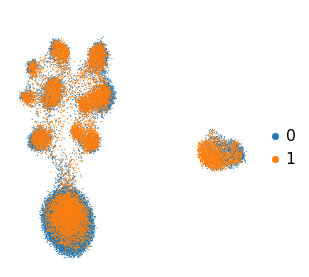

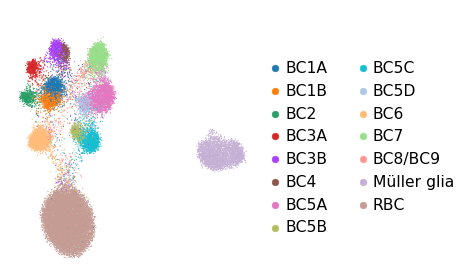

In [36]:
adata.obs['Batch'] = adata.obs['Batch'].astype('category')
adata.obs['Cell type'] = adata.obs['Cell type'].astype('category')
sc.pl.umap(adata, color='Batch', frameon=False, legend_fontsize=14, title=' ', save='_vega_batch.pdf')
sc.pl.umap(adata, color='Cell type', frameon=False, legend_fontsize=14, title=' ', save='_vega_ct.pdf')

## Linear scVI

In [23]:
adata_lvae = adata.copy()
scvi.data.setup_anndata(adata_lvae, layer='count', batch_key='Batch')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     Using batches from adata.obs["Batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 26439 cells, 4000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [24]:
model_lvae = scvi.model.LinearSCVI.load('../trained_models/retina/lvae_retina/')
print(model_lvae)
adata_lvae.obsm['X_scvi'] = model_lvae.get_latent_representation(adata_lvae)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     Using data from adata.layers["count"]                                               
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 26439 cells, 4000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [25]:
sc.pp.neighbors(adata_lvae, use_rep="X_scvi")
sc.tl.umap(adata_lvae)

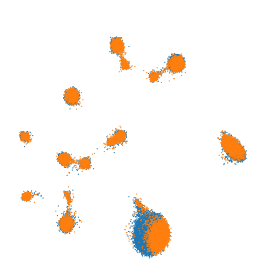

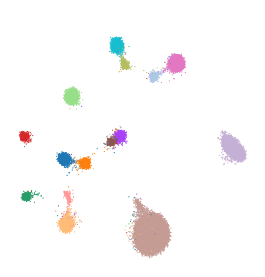

In [37]:
sc.pl.umap(adata_lvae, color='Batch', frameon=False, title=" ", legend_loc = None, save='_lscvi_batch.pdf')
sc.pl.umap(adata_lvae, color='Cell type', frameon=False, title=" ", legend_loc = None, save='_lscvi_ct.pdf')

## Baseline PCA

In [27]:
# Baseline PCA
adata_pca = adata.copy()
sc.pp.scale(adata_pca)
sc.tl.pca(adata_pca, n_comps=50)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [28]:
sc.pp.neighbors(adata_pca, use_rep='X_pca')
sc.tl.umap(adata_pca)

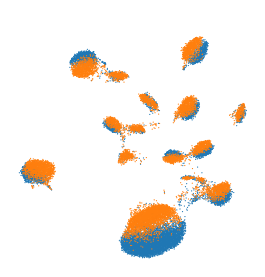

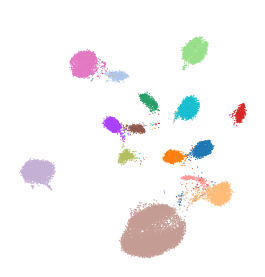

In [38]:
sc.pl.umap(adata_pca, color='Batch', frameon=False, title=" ", legend_loc = None, save='_pca_batch.pdf')
sc.pl.umap(adata_pca, color='Cell type', frameon=False, title=" ", legend_loc = None, save='_pca_ct.pdf')

## Silhouette scores

In [31]:
# Compare ASW
from sklearn.metrics import silhouette_score
asw_vega = silhouette_score(X=adata.obsm['X_vega'], labels=adata.obs['Batch'], random_state=42)
asw_lvae = silhouette_score(X=adata_lvae.obsm['X_scvi'], labels=adata_lvae.obs['Batch'], random_state=42)
asw_pca = silhouette_score(X=adata_pca.obsm['X_pca'], labels=adata_pca.obs['Batch'], random_state=42)
print('VEGA ASW:', asw_vega)
print('LinearSCVI ASW:', asw_lvae)
print('PCA ASW (baseline):', asw_pca)

VEGA ASW: 0.0059060683
LinearSCVI ASW: 0.0024102246
PCA ASW (baseline): 0.03798105
